# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

## Get Data from Webpage and Save to CSV

Do this step one time only and save the table to a csv file

`pip3 install lxml html5lib`

In [3]:
if 0:
    df = pd.read_html(
        r"https://www.mammothmountain.com/on-the-mountain/snowfall-history#tab=historical%20df"
    )[0]
    df.to_csv("./data/mammoth_mountain_snowfall.csv")

## Read table

In [4]:
df = pd.read_csv("./data/mammoth_mountain_snowfall.csv")
display(df.head())

,Unnamed: 0,Season,Total,Pre-Oct,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul
0,0,2023-24,354.0,0,0.0,14.0,12.0,72.0,133.0,95.0,28.0,NaN,NaN,NaN
1,1,2022-23,715.0,0,0.0,61.0,116.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2,2021-22,260.0,0,32.0,9.0,161.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0
3,3,2020-21,244.5,0,0.0,21.0,33.0,108.5,22.0,53.0,5.0,2.0,0.0,0.0
4,4,2019-20,281.0,0,0.0,54.0,71.0,13.0,0.0,83.0,57.0,3.0,0.0,0.0


## Light Cleanups

Some cleanups to do
- Drop dummy row index column and total snowfall per year
- Fill NaN with 0
- Flip from top to bottom to make oldest to newest
- Reorganize by calendar year and month rather than season
- Set index as date in datetime format
- Divide Pre-Oct column into August and September
    - For now, use an even split
    - Should more actually go to September?

In [5]:
df = pd.read_csv("./data/mammoth_mountain_snowfall.csv")
# print("read")
# display(df.head(3))

# print("fillna and dummy drop")
df = df.fillna(0).drop(columns=["Unnamed: 0", "Total"])
# display(df.head(3))

# print("Split pre-october")
df.insert(loc=1, column="Sep", value=0.5 * df["Pre-Oct"])
df.insert(loc=1, column="Aug", value=0.5 * df["Pre-Oct"])
df.drop(columns="Pre-Oct", inplace=True)
# display(df.head(3))

# print("Remove trailing dash from season and convert to int")
df["Season"] = df["Season"].apply(lambda x: int(x.split("-")[0]))
# display(df.head(3))

# print("Renamed season to Year")
df.rename(columns={"Season": "Winter Year"}, inplace=True)
# display(df.head(3))

print("Add current year column for spring months")
df.insert(
    loc=df.columns.get_loc("Jan"),
    column="Spring Year",
    value=df["Winter Year"] + 1,
)

display(df.head(3))

# print("This year")
current_year = df[df.columns[: df.columns.get_loc("Spring Year")]]
# display(current_year.head(3))

# print("Next year")
next_year = df[df.columns[df.columns.get_loc("Spring Year") :]]
# display(next_year.head(3))

print("Merge on year columns")
df = (
    pd.merge(
        current_year,
        next_year,
        left_on="Winter Year",
        right_on="Spring Year",
        how="outer",
    )
    .fillna(0)
    .iloc[::-1]
    .reset_index(drop=True)
)
display(df.head(3))

print("Fill in 0 Values For 2 Edge Years and Drop")
df.insert(
    loc=0,
    column="Year",
    value=df[["Winter Year", "Spring Year"]].max(axis=1).astype(int),
)
df.drop(columns=["Winter Year", "Spring Year"], inplace=True)
display(df.head(3))

Add current year column for spring months


,Winter Year,Aug,Sep,Oct,Nov,Dec,Spring Year,Jan,Feb,Mar,Apr,May,Jun,Jul
0,2023,0.0,0.0,0.0,14.0,12.0,2024,72.0,133.0,95.0,28.0,0.0,0.0,0.0
1,2022,0.0,0.0,0.0,61.0,116.0,2023,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2021,0.0,0.0,32.0,9.0,161.0,2022,0.0,7.0,14.0,34.0,3.0,0.0,0.0


Merge on year columns


,Winter Year,Aug,Sep,Oct,Nov,Dec,Spring Year,Jan,Feb,Mar,Apr,May,Jun,Jul
0,0.0,0.0,0.0,0.0,0.0,0.0,2024.0,72.0,133.0,95.0,28.0,0.0,0.0,0.0
1,2023.0,0.0,0.0,0.0,14.0,12.0,2023.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2022.0,0.0,0.0,0.0,61.0,116.0,2022.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0


Fill in 0 Values For 2 Edge Years and Drop


,Year,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul
0,2024,0.0,0.0,0.0,0.0,0.0,72.0,133.0,95.0,28.0,0.0,0.0,0.0
1,2023,0.0,0.0,0.0,14.0,12.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2022,0.0,0.0,0.0,61.0,116.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0


In [6]:
df.tail()

,Year,Aug,Sep,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul
51,1973,22.5,22.5,0.0,0.0,45.0,84.9,103.0,43.0,10.0,4.0,0.0,0.0
52,1972,2.0,2.0,0.0,57.1,64.5,32.2,11.0,1.0,53.5,0.0,0.0,0.0
53,1971,11.0,11.0,0.0,9.0,139.8,29.0,19.5,24.0,14.0,0.0,0.0,0.0
54,1970,30.0,30.0,0.0,0.0,109.0,78.0,30.5,46.0,27.0,0.0,0.0,0.0
55,1969,11.0,11.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Break Out Months to Rows and Set Date as Index

In [7]:
df = (
    pd.melt(
        df,
        id_vars=df.columns[0],
        value_vars=df.columns[1:],
        var_name="Month",
        value_name="Snow Fall",
    )
    .sort_values(by="Year")
    .iloc[::-1]
    .reset_index(drop=True)
)
df.head()

,Year,Month,Snow Fall
0,2024,Aug,0.0
1,2024,Jun,0.0
2,2024,Mar,95.0
3,2024,Feb,133.0
4,2024,Jan,72.0


In [8]:
df.insert(
    loc=0,
    column="Date",
    value=pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"]),
)
df.head()

,Date,Year,Month,Snow Fall
0,2024-08-01,2024,Aug,0.0
1,2024-06-01,2024,Jun,0.0
2,2024-03-01,2024,Mar,95.0
3,2024-02-01,2024,Feb,133.0
4,2024-01-01,2024,Jan,72.0


In [9]:
df = df.sort_values(by="Date").set_index("Date").drop(columns=["Year"])
df.head()

,Month,Snow Fall
Date,,
1969-01-01,Jan,0.0
1969-02-01,Feb,0.0
1969-03-01,Mar,0.0
1969-04-01,Apr,0.0
1969-05-01,May,0.0


In [10]:
df.tail()

,Month,Snow Fall
Date,,
2024-08-01,Aug,0.0
2024-09-01,Sep,0.0
2024-10-01,Oct,0.0
2024-11-01,Nov,0.0
2024-12-01,Dec,0.0


In [11]:
if 1:
    df = df[:"2024-07-01"]
    display(df.head())
    display(df.tail())

,Month,Snow Fall
Date,,
1969-01-01,Jan,0.0
1969-02-01,Feb,0.0
1969-03-01,Mar,0.0
1969-04-01,Apr,0.0
1969-05-01,May,0.0


,Month,Snow Fall
Date,,
2024-03-01,Mar,95.0
2024-04-01,Apr,28.0
2024-05-01,May,0.0
2024-06-01,Jun,0.0
2024-07-01,Jul,0.0


## Plot After All Transformations

### Plot All Data

In [12]:
y_all = df["Snow Fall"]

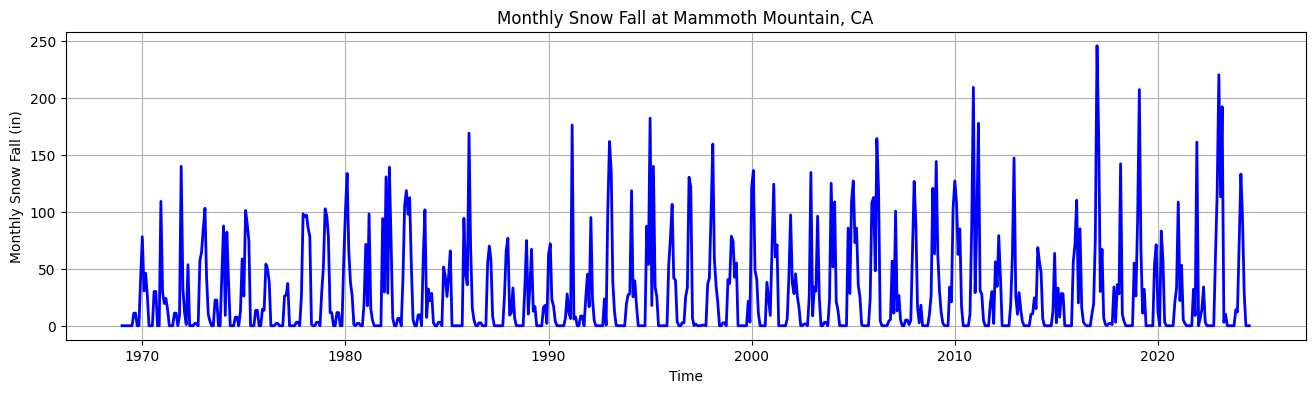

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(y_all, color="blue", lw=2)
plt.title("Monthly Snow Fall at Mammoth Mountain, CA")
plt.xlabel("Time")
plt.ylabel("Monthly Snow Fall (in)")
# plt.legend(loc="upper left")
plt.show()

### Plot First Difference of Data

In [14]:
y_diff = df["Snow Fall"].diff().dropna()

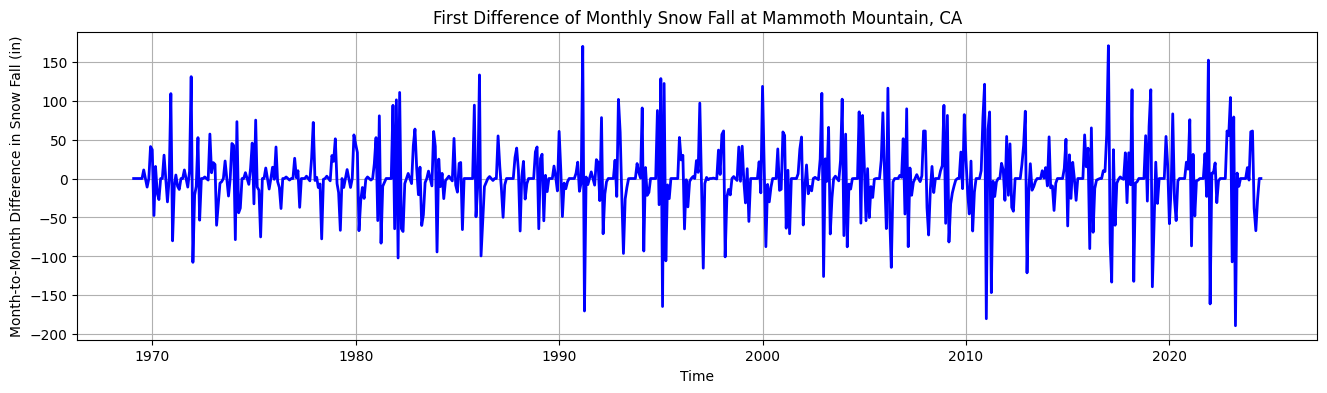

In [15]:
plt.figure(figsize=(16, 4))
plt.plot(y_diff, color="blue", lw=2)
plt.title("First Difference of Monthly Snow Fall at Mammoth Mountain, CA")
plt.xlabel("Time")
plt.ylabel("Month-to-Month Difference in Snow Fall (in)")
# plt.legend(loc="upper left")
plt.show()

### Plot Just January Data

In [16]:
y_january = df.query("Month == 'Jan'")["Snow Fall"]

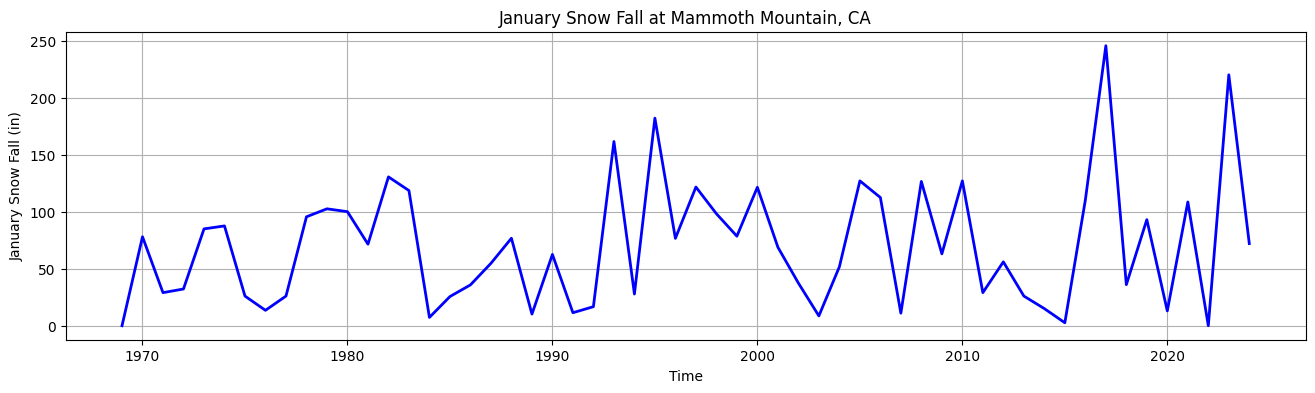

In [17]:
plt.figure(figsize=(16, 4))
plt.plot(y_january, color="blue", lw=2)
plt.title("January Snow Fall at Mammoth Mountain, CA")
plt.xlabel("Time")
plt.ylabel("January Snow Fall (in)")
# plt.legend(loc="upper left")
plt.show()

# Assess Stationarity of Data

## Helper Function for ADF

Becase it is so confusing to my little simian mind

In [18]:
def interpret_adfuller(dftest) -> dict:
    adfd = dict(
        zip(
            [
                "adf",
                "pvalue",
                "usedlag",
                "nobs",
                "critical values",
            ],
            dftest[0:5],
        )
    )

    rejection_confidence = None
    for ci in [1, 5, 10]:
        # Null hypothesis: non-stationarity exists
        # If can reject, hypothesis is false, so is stationary
        # Can reject if ADF less than crit value and pvalue less than ci
        key = "Reject Null per %d%% Level" % ci
        adfd[key] = (
            adfd["adf"] < adfd["critical values"][str(ci) + "%"]
            and adfd["pvalue"] < ci / 100.0
        )
        if adfd[key] and rejection_confidence is None:
            rejection_confidence = ci

    adfd["Process Is"] = (
        "Not Stationary"
        if rejection_confidence is None
        else "Stationary, with %d%% Confidence" % (100 - rejection_confidence)
    )
    return adfd

## All Data - Very Non-Stationary

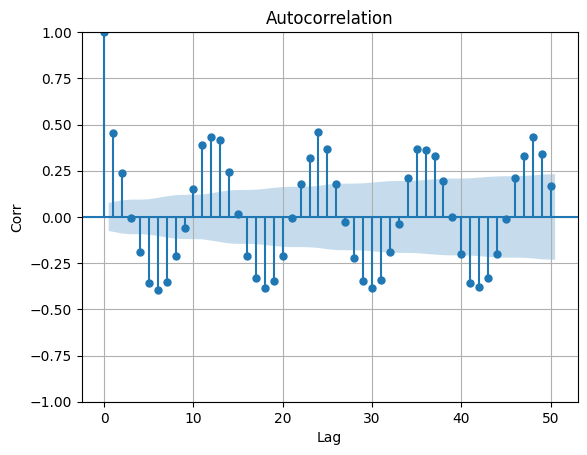

In [19]:
plot_acf(y_all, lags=50)
plt.xlabel("Lag")
plt.ylabel("Corr")
plt.show()

## Difference of Log of Data - Stationary

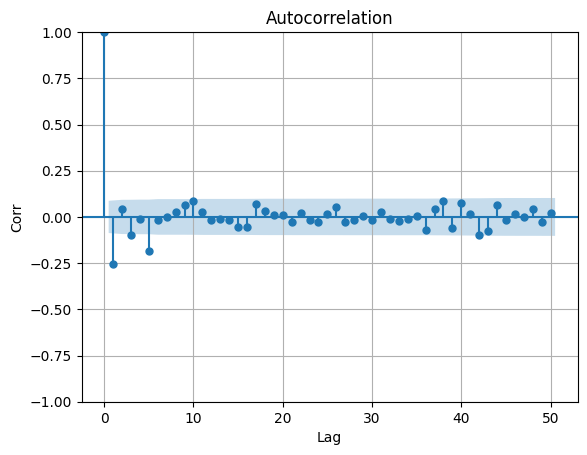

In [20]:
y_log = np.log(y_all).diff().dropna()
y_log[np.isinf(y_log)] = 0.0
plot_acf(y_log, lags=50)
plt.xlabel("Lag")
plt.ylabel("Corr")
plt.show()

## First Difference of Data - Stationary

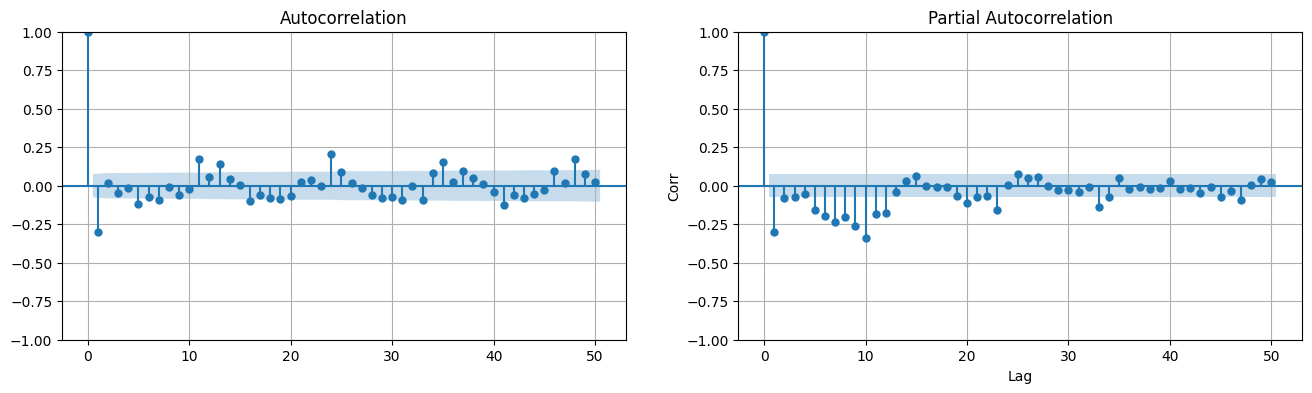

In [21]:
(fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
plot_acf(y_diff, lags=50, ax=ax[0])
plt.xlabel("Lag")
plt.ylabel("Corr")
plot_pacf(y_diff, lags=50, ax=ax[1])
plt.xlabel("Lag")
plt.ylabel("Corr")
plt.show()

## Just January Data - Very Stationary

In [22]:
# (fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
# plot_acf(y_january, lags=20, ax=ax[0])
# plt.xlabel("Lag")
# plt.ylabel("Corr")
# plot_pacf(y_january, lags=20, ax=ax[1])
# plt.xlabel("Lag")
# plt.ylabel("Corr")
# plt.show()

In [23]:
display(interpret_adfuller(adfuller(y_january)))

{'adf': -7.969501588563119,
 'pvalue': 2.8059739086264015e-12,
 'usedlag': 0,
 'nobs': 55,
 'critical values': {'1%': -3.5552728880540942,
  '5%': -2.9157312396694217,
  '10%': -2.5956695041322315},
 'Reject Null per 1% Level': True,
 'Reject Null per 5% Level': True,
 'Reject Null per 10% Level': True,
 'Process Is': 'Stationary, with 99% Confidence'}

In [24]:
display(interpret_adfuller(adfuller(y_all)))

{'adf': -6.122739524303593,
 'pvalue': 8.775481330378182e-08,
 'usedlag': 16,
 'nobs': 650,
 'critical values': {'1%': -3.4404504809576695,
  '5%': -2.8659967824852073,
  '10%': -2.569143417751479},
 'Reject Null per 1% Level': True,
 'Reject Null per 5% Level': True,
 'Reject Null per 10% Level': True,
 'Process Is': 'Stationary, with 99% Confidence'}

In [25]:
display(interpret_adfuller(adfuller(y_diff)))

{'adf': -9.736856668857511,
 'pvalue': 8.703679217642363e-17,
 'usedlag': 20,
 'nobs': 645,
 'critical values': {'1%': -3.4405290941696722,
  '5%': -2.8660314117601575,
  '10%': -2.569161868277147},
 'Reject Null per 1% Level': True,
 'Reject Null per 5% Level': True,
 'Reject Null per 10% Level': True,
 'Process Is': 'Stationary, with 99% Confidence'}

# Train / Test Split

In [26]:
n_months_future = 16
y_history = y_all[: len(y_all) - n_months_future]
y_future = y_all[len(y_all) - n_months_future :]

# Use Seasonal Decomp

### Fit and Forecast with STL

In [27]:
period = 12
stl = STL(y_history, period=period).fit()
y_fit_sd = stl.trend + stl.seasonal
# display(interpret_adfuller(adfuller(stl.resid)))

In [28]:
stlf = STLForecast(
    y_history, ARIMA, model_kwargs={"order": (1, 1, 0), "trend": "t"}, period=period
).fit()
y_forecast_sd = stlf.forecast(len(y_future))
y_forecast_sd.index = y_future.index

### Calculate Errors

In [29]:
mae_fit_sd = np.abs(stl.resid).mean()
rmse_fit_sd = np.sqrt((stl.resid**2).mean())
mae_forecast_sd = np.abs(y_future - y_forecast_sd).mean()
rmse_forecast_sd = root_mean_squared_error(y_future, y_forecast_sd)
[mae_fit_sd, rmse_fit_sd, mae_forecast_sd, rmse_forecast_sd]

[14.951949424097473, 23.09746895357835, 112.68523242013484, 119.26198478680053]

### Plot Residual

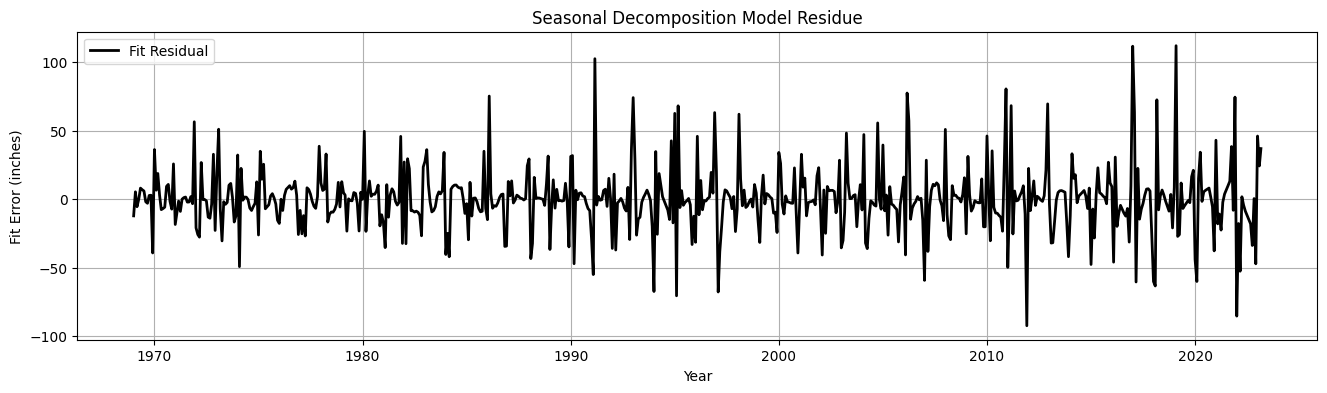

In [30]:
plt.figure(figsize=(16, 4))
plt.plot(stl.resid, color="black", lw=2, label="Fit Residual")
plt.title("Seasonal Decomposition Model Residue")
plt.xlabel("Year")
plt.ylabel("Fit Error (inches)")
plt.legend(loc="upper left")
plt.show()

# Use SARIMA

### Fit and Forecast with SARIMA

In [31]:
p = 1
q = 1
diffs = 0
sarima = SARIMAX(y_history, order=(1, 0, 1), seasonal_order=(1, 1, 0, period)).fit(
    disp=0
)
y_fit_sarima = sarima.predict()
y_forecast_sarima = sarima.forecast(steps=len(y_future))

### Calculate Errors

In [32]:
mae_fit_sarima = np.abs(sarima.resid).mean()
rmse_fit_sarima = np.sqrt((sarima.resid**2).mean())
mae_forecast_sarima = np.abs(y_future - y_forecast_sarima).mean()
rmse_forecast_sarima = root_mean_squared_error(y_future, y_forecast_sarima)
[mae_fit_sarima, rmse_fit_sarima, mae_forecast_sarima, rmse_forecast_sarima]

[22.18241324699077, 36.9777563647976, 25.23792891826495, 41.761942136507976]

# Overlaying Plots with Both

## All Data, with Fit and Forecast

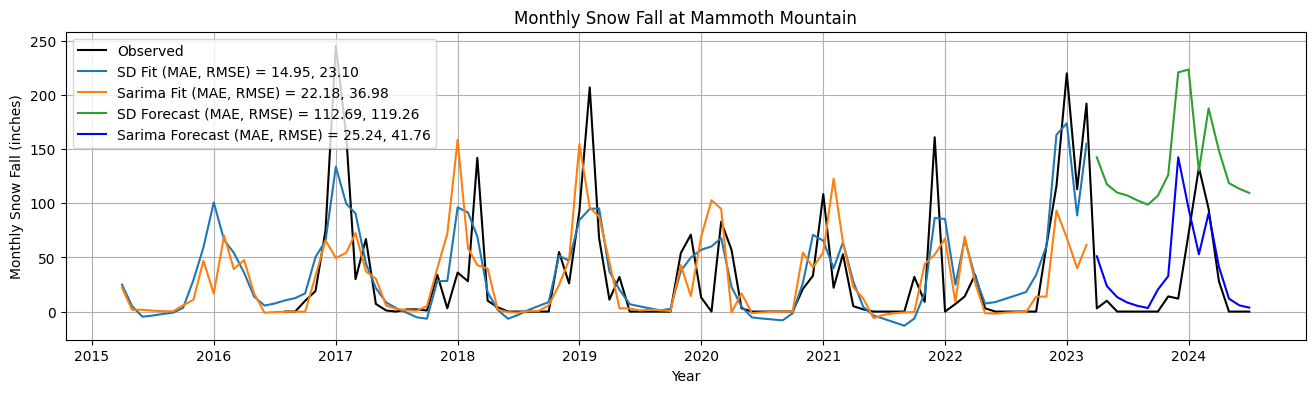

In [33]:
nplot = 6 * n_months_future
plt.figure(figsize=(16, 4))
plt.plot(y_all[-nplot:], color="black", label="Observed")
plt.plot(
    y_fit_sd[-nplot:],
    label="SD Fit (MAE, RMSE) = %.2f, %.2f" % (mae_fit_sd, rmse_fit_sd),
)
plt.plot(
    y_fit_sarima[-nplot:],
    label="Sarima Fit (MAE, RMSE) = %.2f, %.2f" % (mae_fit_sarima, rmse_fit_sarima),
)
plt.plot(
    y_forecast_sd[-nplot:],
    label="SD Forecast (MAE, RMSE) = %.2f, %.2f" % (mae_forecast_sd, rmse_forecast_sd),
)
plt.plot(
    y_forecast_sarima[-nplot:],
    color="blue",
    label="Sarima Forecast (MAE, RMSE) = %.2f, %.2f"
    % (mae_forecast_sarima, rmse_forecast_sarima),
)
plt.title("Monthly Snow Fall at Mammoth Mountain")
plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="upper left")
plt.show()

## Forecast Only, with Errors Overlaid

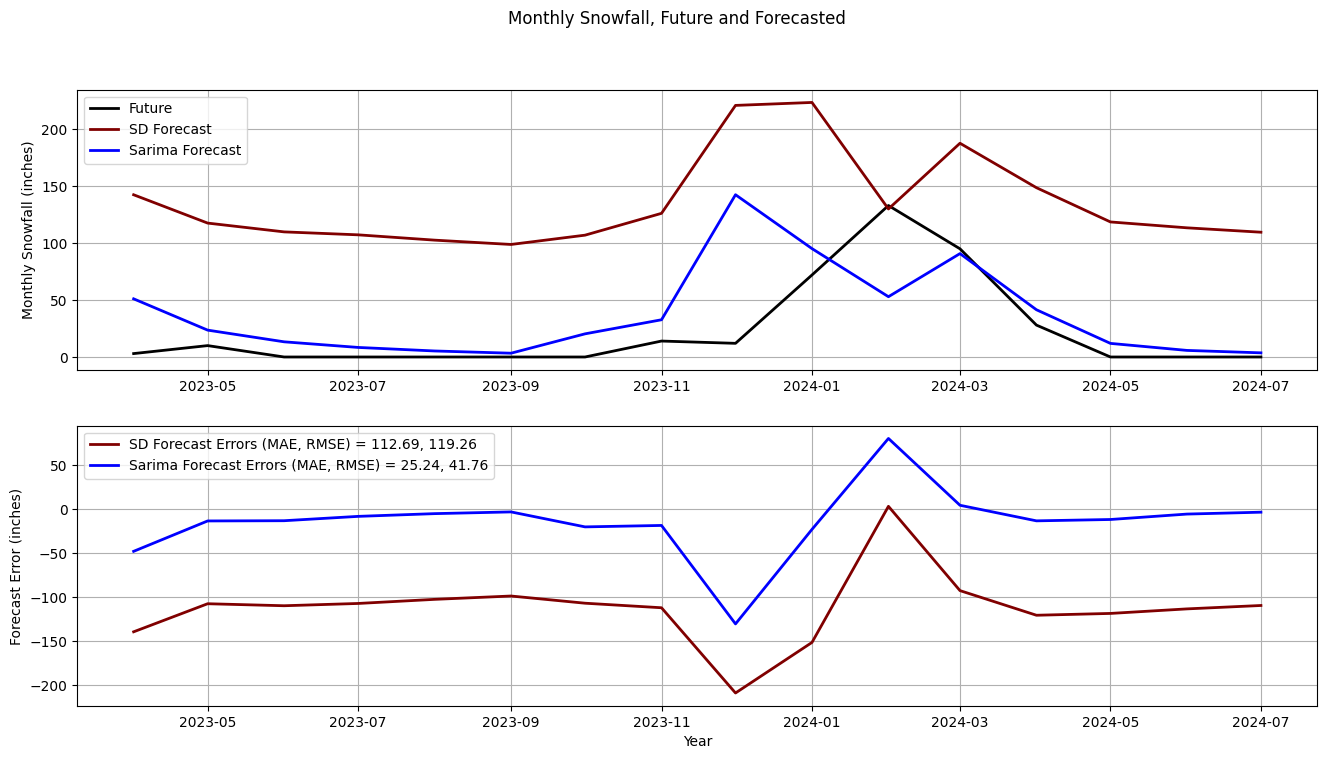

In [34]:
(fig, ax) = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
forecast_str = "Forecast Errors (inches): MAE = %.2f, RMSE = %.2f" % (
    mae_forecast_sarima,
    rmse_forecast_sarima,
)
ax[0].plot(y_future, color="black", lw=2, label="Future")
ax[0].plot(y_forecast_sd, color="maroon", lw=2, label="SD Forecast")
ax[0].plot(y_forecast_sarima, color="blue", lw=2, label="Sarima Forecast")
ax[0].set_ylabel("Monthly Snowfall (inches)")
ax[0].legend(loc="upper left")

ax[1].plot(
    y_future - y_forecast_sd,
    color="maroon",
    lw=2,
    label="SD Forecast Errors (MAE, RMSE) = %.2f, %.2f"
    % (mae_forecast_sd, rmse_forecast_sd),
)

ax[1].plot(
    y_future - y_forecast_sarima,
    color="blue",
    lw=2,
    label="Sarima Forecast Errors (MAE, RMSE) = %.2f, %.2f"
    % (mae_forecast_sarima, rmse_forecast_sarima),
)

ax[1].set_xlabel("Year")
ax[1].set_ylabel("Forecast Error (inches)")
ax[1].legend(loc="upper left")

plt.suptitle("Monthly Snowfall, Future and Forecasted")
plt.show()